In [492]:
import numpy as np
import matplotlib.pyplot as plt
from parse import parse
import cv2

In [1078]:
train_images, train_labels = parse('facedata/facedatatrain', 'facedata/facedatatrainlabels', False)
validation_images, validation_labels = parse('facedata/facedatavalidation', 'facedata/facedatavalidationlabels', False)
test_images, test_labels = parse('facedata/facedatatest', 'facedata/facedatatestlabels', False)

In [235]:
base_rate_true = np.bincount(train_labels)/train_labels.shape[0]
print(base_rate_true)

[0.51884701 0.48115299]


In [782]:
kernel = np.ones((7,6))
images = np.swapaxes(np.swapaxes(train_images.astype(np.float64), 0, 2), 0, 1)
dst = cv2.filter2D(src = images, ddepth = -1, kernel = kernel, anchor = (0,0))
zones = dst[::7,::6,:]

In [ ]:
a = 0
plt.imshow(train_images[a,:,:])
plt.show()
plt.imshow(dst[:,:,a])
plt.show()
plt.imshow(dst[::7,::6,a])
plt.show()
plt.imshow(zones[:,:,a])

In [1091]:
def get_feature_probs(images = train_images, labels = train_labels, dim = (7,6), stride = -1, kernel = -1):

    labels = labels.astype(bool)

    if stride == -1:
        stride = dim

    if kernel == -1:
        kernel = np.ones(dim)

    pixel_quant = dim[0]*dim[1] + 1

    kernel = np.ones(dim)
    images = np.swapaxes(np.swapaxes(images.astype(np.float64), 0, 2), 0, 1)
    dst = cv2.filter2D(src = images, ddepth = -1, kernel = kernel, anchor = (0,0))

    zones = dst[::stride[0],::stride[1],:].astype(int)
    zones = np.reshape(zones, (zones.shape[0]*zones.shape[1], zones.shape[2]))

    zone_probs = np.zeros((zones.shape[0], pixel_quant, 2))

    for i, zone in enumerate(zones):
        quant_false = np.bincount(zone[np.invert(labels)])
        quant_false = np.pad(quant_false, (0, pixel_quant - quant_false.shape[0]), constant_values = 0)
        quant_false = quant_false/np.sum(quant_false)

        quant_true = np.bincount(zone[labels])
        quant_true = np.pad(quant_true, (0, pixel_quant - quant_true.shape[0]), constant_values = 0)
        quant_true = quant_true/np.sum(quant_true)

        zone_probs[i, :, 0], zone_probs[i, :, 1] = quant_false, quant_true

        zeros = zone_probs == 0
        zone_probs[zeros] = 0.000001

    return zone_probs

In [1092]:
def get_features(images = train_images, dim = (7,3), stride = -1, kernel = -1):
    if stride == -1:
        stride = dim

    if kernel == -1:
        kernel = np.ones(dim)

    pixel_quant = dim[0]*dim[1] + 1

    kernel = np.ones(dim)
    images = np.swapaxes(np.swapaxes(images.astype(np.float64), 0, 2), 0, 1)
    dst = cv2.filter2D(src = images, ddepth = -1, kernel = kernel, anchor = (0,0))

    zones = dst[::stride[0],::stride[1],:].astype(int)
    zones = np.reshape(zones, (zones.shape[0]*zones.shape[1], zones.shape[2]))
    #zones = np.swapaxes(zones, 0, 1)

    return zones

In [1093]:
def predict(train_images = train_images, train_labels = train_labels, val_images = validation_images, val_labels = validation_labels):
    dim = (7,3)

    base_rate_true = np.bincount(train_labels)/train_labels.shape[0]

    feature_probs = get_feature_probs(train_images, train_labels, dim, )
    train_features = get_features(train_images, dim)
    val_features = get_features(val_images, dim)

    train_image_probs = np.product(feature_probs[np.arange(len(train_features))[:, np.newaxis], train_features], axis = 0)
    train_preds = train_image_probs[:,0]*base_rate_true[0] < train_image_probs[:,1]*base_rate_true[1]
    train_acc = np.sum(train_preds == train_labels)/train_labels.shape[0]

    val_image_probs = np.product(feature_probs[np.arange(len(val_features))[:, np.newaxis], val_features], axis = 0)
    val_preds = val_image_probs[:,0]*base_rate_true[0] < val_image_probs[:,1]*base_rate_true[1]
    val_acc = np.sum(val_preds == val_labels)/val_labels.shape[0]

    return train_acc, val_acc


In [1103]:
accuracy = np.zeros((10, 2), dtype= np.float64)
for i in range(1, 11):
    ammount = int(0.1 * i * train_images.shape[0] )
    available_indices = np.random.choice(train_images.shape[0], ammount, replace = False)
    available_images = train_images[available_indices]
    available_labels = train_labels[available_indices]
    accuracy[i-1] = np.array(predict(available_images, available_labels, validation_images, validation_labels))
print(accuracy[-1,:])

[0.98891353 0.94352159]


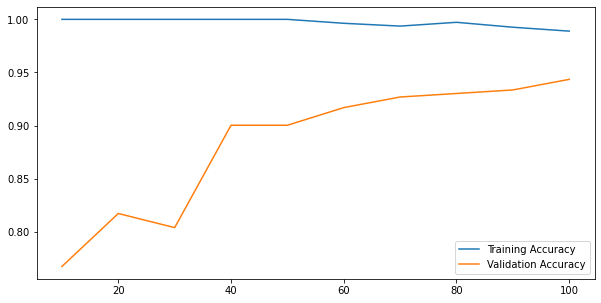

In [1104]:
plt.figure(figsize = (10, 5))
x = np.linspace(10, 100, 10)
plt.plot(x, accuracy[:,0], label = "Training Accuracy")
plt.plot(x, accuracy[:,1], label = "Validation Accuracy")
plt.legend()